In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Q1. 3.2.

In [123]:
def clgs(A):
  m, n = np.shape(A)
  V = A.copy()
  Q = np.eye(m, n)
  R = np.zeros((n, n))
  
  for j in range(n):
    for i in range(j):
      R[i, j] = Q[:, i].conj().T @ A[:,j]
      V[:, j] = V[:, j] - R[i, j] * Q[:, i]
    R[j, j] = np.linalg.norm(V[:, j])
    Q[:, j] = V[:, j] / R[j, j]
    
  return Q, R

In [3]:
def mgs(A):
  m, n = np.shape(A)
  Q = A.copy()
  R = np.zeros((n, n))
  for i in range(n-1):
    R[i, i] = np.linalg.norm(Q[:, i])
    Q[:, i] = Q[:, i] / R[i, i]
    R[i, i+1:] = Q[:, i].conj().T @ Q[:,i+1:]
    Q[:, i+1:] = Q[:, i+1:] - np.outer(Q[:, i],  R[i, i+1:])
  R[n-1, n-1] = np.linalg.norm(Q[:, n-1])
  Q[:, n-1] = Q[:, n-1] / R[n-1, n-1]
  
  return Q, R

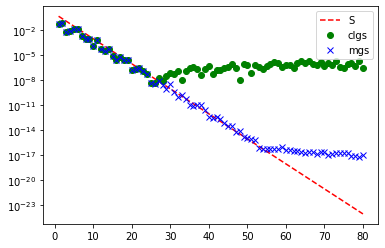

In [4]:
U, X = np.linalg.qr(np.random.randn(80, 80))
V, X = np.linalg.qr(np.random.randn(80, 80))

S = np.diag(np.array([2**(-i) for i in range(1, 81)])).astype(np.float)

A = U @ S @ V
A = A.astype(np.float)

Qc, Rc = clgs(A)
Qm, Rm = mgs(A)

j = np.arange(1, 81)
s_jj = S.diagonal()
rc_jj = Rc.diagonal()
rm_jj = Rm.diagonal()

plt.semilogy(j, s_jj, 'r--', label='S')
plt.semilogy(j, rc_jj, 'go', label='clgs')
plt.semilogy(j, rm_jj, 'bx', label='mgs')

plt.legend()
plt.show()

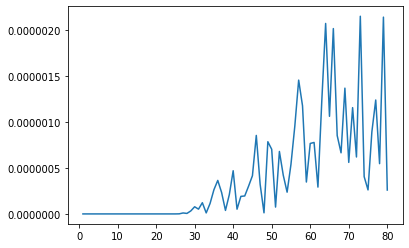

In [5]:
plt.plot(j, rc_jj-rm_jj)
plt.show()

작은 오차가 누적되어 큰 차이가 형성된 것을 관찰할 수 있었다.

In [124]:
def qrhouse(A):
  m, n = np.shape(A)
  R = A.copy()
  V = np.zeros((m, n))
  
  for k in range(min(m-1, n)):
    x = R[k:, k]
    v = x + np.sign(x[0]) * np.linalg.norm(x) * np.eye(len(x), 1).reshape(-1)
    
    V[k:, k] = v
    R[k:, k:] = R[k:, k:] - np.outer((2*v), (v.conj().T @ R[k:, k:]) / (v.conj().T @ v))
    
  R = np.triu(R[:n,:])
  
  return V, R

In [69]:
def formQ(V):
  m, n = np.shape(V)
  Q = np.eye(m)
  for j in range(min(m-1, n)-1, -1, -1):
    v = V[:, j]
    Q = Q - np.outer((2*v), (v.conj().T @ Q) / (v.conj().T @ v))
    
  return Q

In [107]:
A = np.array([
  [.70000, .70711],
  [.70001, .70711],
]).astype(np.float64)

Qm, Rm = mgs(A)
V, R = qrhouse(A)
Q = formQ(V)

print(np.linalg.norm(Q.conj().T @ Q - np.eye(2)))
print(np.linalg.norm(Qm.conj().T @ Qm - np.eye(2)))

(2,)
5.787252299533512e-16
3.254726094493924e-11


householder의 오차가 더 작다.

## Q2. 3.3.

In [9]:
def givens(A):
  m, n = np.shape(A)
  Q = np.eye(m)
  R = A.copy()
  
  for k in range(n):
    for i in range(m-1, k, -1):
      if abs(R[i-1, k]) <= 1e-8:
        continue
      G = np.eye(m)
      r = (R[i, k]**2 + R[i-1, k]**2)**0.5
      c = R[i-1, k]/r
      s = -R[i,k]/r
      G[i-1, i] = -s
      G[i, i-1] = s
      G[i, i]= c
      G[i-1, i-1] = c
      
      R = G @ R
      Q = Q @ G.T
  
  for i in range(0, m, 2):
    Q[:, i] *= -1
  for i in range(0, n, 2):
    R[i, :] *= -1
  
  return Q, R
  

In [10]:
A = np.array([
  [6,5,0],
  [5,1,4],
  [0,4,3]
])

Qg, Rg = givens(A)
Q, R = np.linalg.qr(A)


print("Qg=\n",Qg)
print("Q=\n",Q)
print("Rg=\n",Rg)
print("R=\n",R)

Qg=
 [[-0.76822128  0.33265418 -0.54697099]
 [-0.6401844  -0.39918502  0.65636519]
 [-0.          0.854396    0.51962244]]
Q=
 [[-0.76822128  0.33265418 -0.54697099]
 [-0.6401844  -0.39918502  0.65636519]
 [-0.          0.854396    0.51962244]]
Rg=
 [[-7.81024968e+00 -4.48129080e+00 -2.56073760e+00]
 [ 2.88448398e-16  4.68166987e+00  9.66447932e-01]
 [-4.74285054e-16 -0.00000000e+00  4.18432806e+00]]
R=
 [[-7.81024968 -4.4812908  -2.5607376 ]
 [ 0.          4.68166987  0.96644793]
 [ 0.          0.          4.18432806]]


## Q3. 4.3.

In [31]:
def get_matrix(m):
  return np.random.randn(m, m) / (m**0.5)

def draw_graph(m, func=get_matrix):
  eigenvalues = np.ndarray(m*100, dtype=complex)
  
  for i in range(100):
    A = func(m)
    for j in range(m):
      eigenvalues[m*i+j] = np.linalg.eig(A)[0][j]
      
  plt.scatter(eigenvalues.real, eigenvalues.imag)
  plt.show()

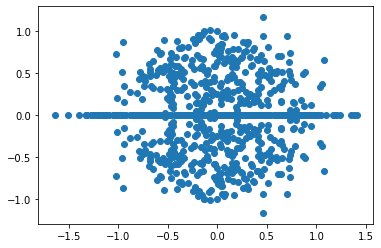

In [32]:
draw_graph(8)

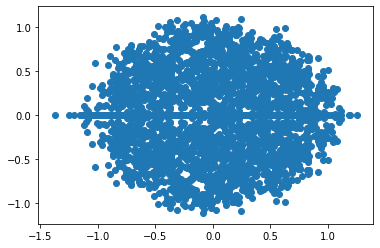

In [33]:
draw_graph(32)

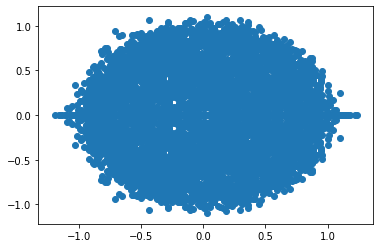

In [17]:
draw_graph(64)

m이 커짐에 따라, p(A)가 타원의 장축의 길이에 점점 가까워지므로, m이 무한대로 할 때 등호가 성립할 것이다.

In [34]:
def draw_graph2(m, func=get_matrix):
  count = np.zeros(10)
  singular = np.array([2**-i for i in range(1, 11)])
  for i in range(100):
    A = func(m)
    U, S, V = np.linalg.svd(A)
    for j in range(10):
      if S[-1] <= singular[j]:
        count[j]+=1
      else:
        break
  plt.plot(singular, count/100, 'o')
  plt.show()

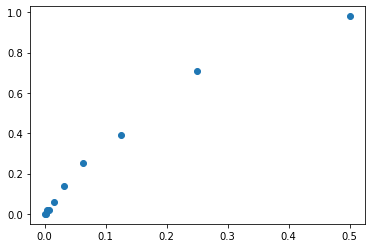

In [25]:
draw_graph2(4)

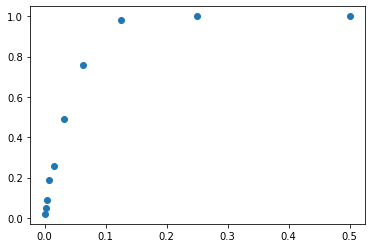

In [26]:
draw_graph2(16)

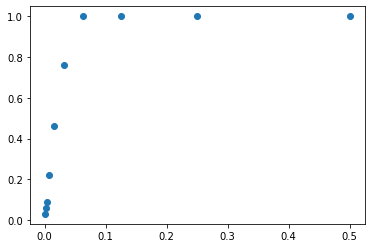

In [27]:
draw_graph2(32)

In [35]:
def get_matrix2(m):
  return np.triu(np.random.randn(m, m) / (m**0.5))

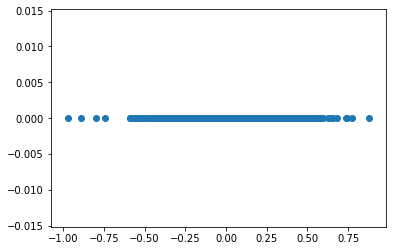

In [36]:
draw_graph(16, get_matrix2)

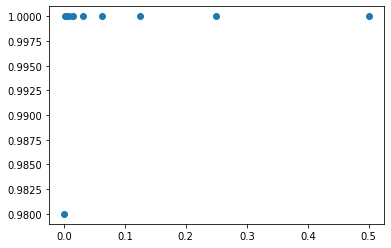

In [37]:
draw_graph2(16, get_matrix2)

## Q4. 4.6.

In [128]:
m = 50
n = 12

t = np.linspace(0, 1, m)
A = np.fliplr(np.vander(t, n))
b = np.cos(4 * t).reshape(-1, 1)

In [131]:
#1
x1 = np.linalg.inv(A.T @ A) @ A.T @ b
print(x1)

[[ 1.01132797]
 [-0.12396076]
 [-7.42414594]
 [-0.86853974]
 [11.08544019]
 [-0.52987632]
 [-4.20744757]
 [-1.84072857]
 [ 2.94203474]
 [-0.6630005 ]
 [-0.10945571]
 [ 0.03939407]]


In [85]:
#2
Q, R = mgs(A)
x2 = np.linalg.solve(R, Q.T @ b)
print(x2)

[[ 1.00000000e+00]
 [-4.58240104e-07]
 [-7.99998009e+00]
 [-3.33437814e-04]
 [ 1.06695290e+01]
 [-1.42085086e-02]
 [-5.64611093e+00]
 [-7.68632224e-02]
 [ 1.69520470e+00]
 [ 5.00761554e-03]
 [-3.73871301e-01]
 [ 8.79830113e-02]]


In [130]:
#3
Q, R = qrhouse(A)
x3 = np.linalg.solve(R, Q.T @ b)

print(x3)

49 12
[[  2.95430125]
 [ -3.49790094]
 [ -4.65514068]
 [  2.57685988]
 [  0.55833261]
 [  1.94197602]
 [ -9.05993868]
 [ 14.13901714]
 [-14.88420062]
 [ 11.4285444 ]
 [ -5.47258763]
 [  1.11591964]]


In [87]:
#4
Q, R = np.linalg.qr(A)
x4 = np.linalg.solve(R, Q.T @ b)
print(x4)

[[ 1.00000000e+00]
 [-4.22743382e-07]
 [-7.99998124e+00]
 [-3.18763322e-04]
 [ 1.06694308e+01]
 [-1.38202901e-02]
 [-5.64707562e+00]
 [-7.53160326e-02]
 [ 1.69360697e+00]
 [ 6.03210277e-03]
 [-3.74241701e-01]
 [ 8.80405757e-02]]


In [89]:
#5
x5 = np.linalg.lstsq(A, b)[0]
print(x5)

[[ 1.00000000e+00]
 [-4.22743385e-07]
 [-7.99998124e+00]
 [-3.18763318e-04]
 [ 1.06694308e+01]
 [-1.38202899e-02]
 [-5.64707562e+00]
 [-7.53160319e-02]
 [ 1.69360697e+00]
 [ 6.03210333e-03]
 [-3.74241701e-01]
 [ 8.80405757e-02]]


C:\Users\rlask\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [92]:
#6
U, S, V = np.linalg.svd(A)

B = np.zeros((n,m))
for i in range(len(S)):
  B[i,i] = 1/S[i]
x6 = V.T @ B @ U.T @ b
print(x6)

[[ 1.00000000e+00]
 [-4.22743378e-07]
 [-7.99998124e+00]
 [-3.18763307e-04]
 [ 1.06694308e+01]
 [-1.38202899e-02]
 [-5.64707562e+00]
 [-7.53160322e-02]
 [ 1.69360697e+00]
 [ 6.03210216e-03]
 [-3.74241701e-01]
 [ 8.80405757e-02]]


대략 값들이 비슷하지만 inv를 구한 경우 오차가 좀 있었다.